# Lab session of 23/03/2022

## Graph problem 2: Minimum Spanning Tree, cutset formulation

Write and solve the cut-set formulation of the Minimum Spanning Tree (MST) for a random graph.

## Solution

A formulation of the MST problem uses *cut sets*: given a graph $G=(V,E)$ with $V$ the set of nodes and $E$ the set of edges, we create binary variables $x_{ij}$ for each $(i,j)\in E$ such that $x_{ij}$ is 1 if $(i,j)$ is in the solution, 0 otherwise. Then the formulation includes $cut set$ inequalities.

A *cut* $\delta(S)$ in a graph $G=(V,E)$ is a subset of edges generated by a subset of nodes $S\subset V$: an edge $(i,j)\in E$ is in $\delta(S)$ if exactly one among $i$ and $j$ is in $S$.


The formulation enforces the following condition:

__For any cut $\delta(S)$ containing the set of edges $(i,j)$ with $i$ in $S\subset V$ and $j$ in $V\setminus S$, there must be at least one edge of $\delta(S)$ in the solution.__

This implies that a formulation for the MST is 

$$
\begin{array}{lll}
  \min & \sum_{(i,j)\in E} c_{ij} x_{ij}\\
  \textrm{s.t.} & \sum_{(i,j)\in \mathcal \delta(S)} x_{ij} \ge 1 & \forall S\subset V:S\neq \emptyset\\
                & x_{ij} \in \{0,1\} & \forall (i,j)\in E
\end{array}
$$

Write the above formulation and solve it for a random graph.

In [46]:
import numpy as np
import math

k = 11 #number of vertices

grid_size = 100 # size of the grid of points

# distance beyond which we don't want edges
d_max = .75 * grid_size

np.random.seed(69104)

# Create k random points with two coordinates. Multiplying by grid_size yields
# random numbers between 0 and 100.
point = np.random.random((k,2)) * grid_size

# Define the set of vertices of the graph as the list of numbers from 0 to k-1
V = [i for i in range(k)]

# Determine the distance between each point
distance = np.array([[math.sqrt(np.sum((point[i] - point[j])**2)) for i in V] for j in V])

# Set of edges: note the condition that i<j (so we have pairs i,j but not j,i)
# and especially the condition that prevents long arcs.
E = [(i,j) for i in V for j in V if i<j and distance[i,j] < d_max]

print(E)

[(0, 1), (0, 2), (0, 4), (0, 5), (0, 6), (0, 9), (0, 10), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (2, 4), (2, 5), (2, 6), (2, 9), (2, 10), (3, 7), (3, 8), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 6), (5, 7), (5, 9), (5, 10), (6, 9), (6, 10), (7, 8)]


Below is code for generating all subsets of a given list of objects. We will use `powerset` to create all constraints of the formulation.

In [47]:
from itertools import chain, combinations
powerset = list(chain.from_iterable(combinations(V, r) for r in V))

We have all we need to write the problem.

In [48]:
import mip

# Create a new model
m = mip.Model()

# Create variables (one for each edge). for tuple (i,j) we have x[i, j]
x = {(i,j): m.add_var(var_type=mip.BINARY) for (i,j) in E}

# Add constraints: each vertex must be in exactly one cutset (no cycles)
# solo un arco attraversa il taglio
for S in powerset:
    if(len(S) > 0 and len(S) < k):
        m.add_constr(mip.xsum(x[i,j] for (i,j) in E
                         if (i in S and j not in S)
                         or (j in S and i not in S))>= 1)

# Set objective: minimize the sum of the weights of the edges in the cutset
m.objective = mip.minimize(mip.xsum(x[i,j] * distance[i,j] for (i,j) in E))

m.optimize()
#m.optimize parameters

# Print the solution
print('Solution status: {}'.format(m.status))
if m.num_solutions:
    print('Optimal value: {}'.format(m.objective_value))
    print('Edges in the cutset:')
    for (i,j) in E:
        if x[i,j].x >= 0.99:
            print((i,j))


maxSavedSolutions was changed from 1 to 10
Continuous objective value is 164.535 - 0.001563 seconds
Cgl0004I processed model has 1023 rows, 43 columns (43 integer (43 of which binary)) and 22016 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 1.149%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 11 integers unsatisfied sum - 5.5
Cbc0038I Pass   1: suminf.    5.50000 (11) obj. 195.575 iterations 28
Cbc0038I Solution found of 391.149
Cbc0038I Rounding solution of 328.96 is better than previous of 391.149
Cbc0038I Before mini branch and bound, 28 integers at bound fixed and 0 continuous
Cbc0038I Full problem 1023 rows 43 columns, reduced to 1023 rows 15 columns - 3 fixed gives 127, 11 - ok now
Cbc0038I Full problem 1023 rows 43 columns, reduced to 127 rows 11 columns
Cbc0012I Integer solution of 327.38121 found by rounding after 3 iterations and 1 nodes (0.06 seconds)
Cbc0012I Integer solution of 302.72691 found by rounding a

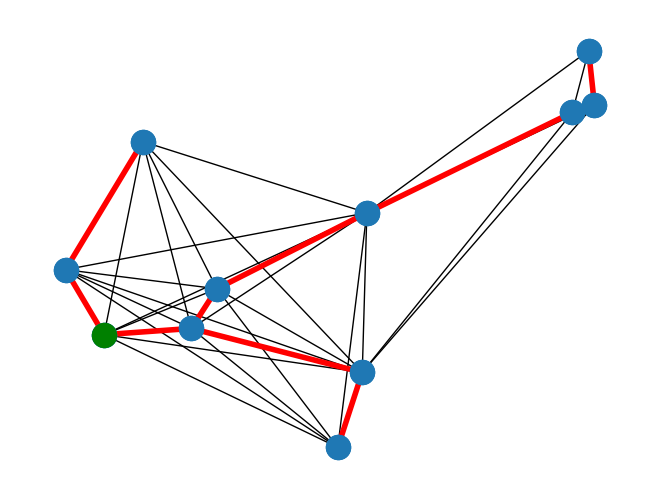

In [49]:
import networkx as nx

def draw_solution(V, A, x):
    g = nx.Graph()

    # Draw the whole graph first: all nodes, all arcs, no highlighting
    g.add_nodes_from(V)
    g.add_edges_from([(i,j) for (i,j) in A])
    nx.draw(g, pos=point)

    # Reset the graph and add only the arcs that belong to the solution, 
    # i.e. those for which the optimal value of the variable f[i,j] is nonzero
    g.clear()
    g.add_edges_from([(i,j) for (i,j) in A if x[i,j].x > 0.001])
    nx.draw(g, pos=point, width=4, edge_color='red')

    # finally, draw a graph consisting of the sole root node, highlighted in green
    g.clear()
    g.add_node(0)
    nx.draw(g, pos={0: point[0]}, node_color='green')
    
# after defining the function, call it with the current data
draw_solution (V, E, x)